# **Setup**



In [ ]:
%cd /content/drive/MyDrive
#!git clone https://github.com/Stability-AI/generative-models.git
%cd generative-models
#
!python3 -m venv .pt2
!source .pt2/bin/activate
!pip3 install -r requirements/pt2.txt
!pip3 install .
!pip3 install -e git+https://github.com/Stability-AI/datapipelines.git@main#egg=sdata
!pip install hatch
!hatch build -t wheel
!pip install diffusers
!pip install -U transformers
#!git clone https://github.com/EliSchwartz/imagenet-sample-images
!pip install torch-fidelity
!pip install -qr https://huggingface.co/briaai/RMBG-1.4/resolve/main/requirements.txt

/content/drive/MyDrive
/content/drive/MyDrive/generative-models
The virtual environment was not created successfully because ensurepip is not
available.  On Debian/Ubuntu systems, you need to install the python3-venv
package using the following command.

    apt install python3.10-venv

You may need to use sudo with that command.  After installing the python3-venv
package, recreate your virtual environment.

Failing command: /content/drive/MyDrive/generative-models/.pt2/bin/python3

/bin/bash: line 1: .pt2/bin/activate: No such file or directory
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-install-kylk2dye/clip_ab2808f59dd043af83b339d70a14182e
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-install-kylk2dye/clip_ab2808f59dd043af83b339d70a14182e
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Using cached tokenizers-0.12.1-cp310-cp310

Exception in thread Thread-6 (attachment_entry):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 237, in listen
    sock, _ = endpoints_listener.accept()
  File "/usr/lib/python3.10/socket.py", line 293, in accept
    fd, addr = self._accept()
TimeoutError: timed out

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/google/colab/_debugpy.py", line 52, in attachment_entry
    debugpy.listen(_dap_port)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/public_api.py", line 31, in wrapper
    return wrapped(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 143, in debug
    log.reraise

Processing /content/drive/MyDrive/generative-models
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for sgm: filename=sgm-0.1.0-py3-none-any.whl size=126611 sha256=b4e795f96292cc7d684940ed67675e57d8b24d3c2e2e344ec0d77d831a478392
  Stored in directory: /root/.cache/pip/wheels/ce/f4/c8/e1e7422a52b0e32050631c29fc557a75e98b8b9d15d3708cd4
Successfully built sgm
  Attempting uninstall: sgm
    Found existing installation: sgm 0.1.0
    Uninstalling sgm-0.1.0:
      Successfully uninstalled sgm-0.1.0
Obtaining sdata from git+https://github.com/Stability-AI/datapipelines.git@main#egg=sdata
  Updating ./src/sdata clone (to revision main)
  Running command git fetch -q --tags
  Running command git reset --hard -q 8bce77d147033b3a5285b6d45ee85f33866964fc
  Preparing metadata (setup.py) ... done
  Attempting uninstall: sdata
    Found existing installation: sdata 0.0.1
    Uninstalling sdata-0.0.

# **Imports**

In [ ]:
import torch
from transformers import UMT5EncoderModel
from diffusers import AutoPipelineForText2Image
from diffusers import DiffusionPipeline
import torch
import pandas as pd
import time
import os
import shutil
import torchvision
from PIL import Image
from transformers import pipeline
import matplotlib.pyplot as plt

# **SDXL and Background Remover**

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

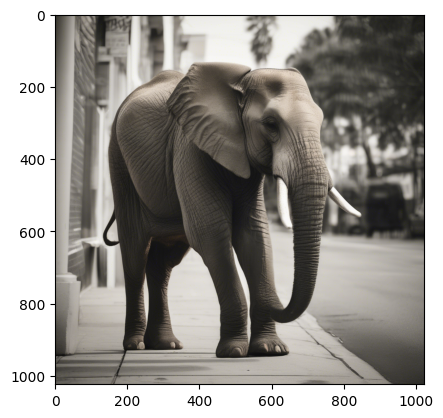

Total Time SDXL: 36.666460 seconds


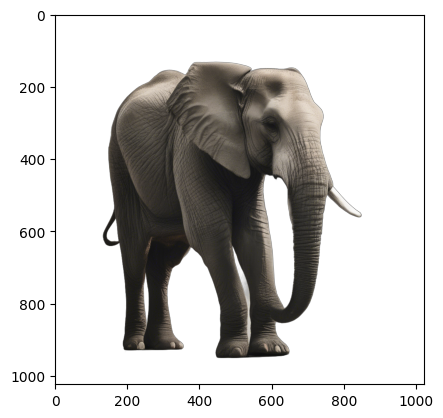

Total Time BG Removal: 1.174252 seconds


In [ ]:
# Check if cuda is available
use_cuda = torch.cuda.is_available()
# Set proper device based on cuda availability
device = torch.device("cuda" if use_cuda else "cpu")

#batch_size = 10


if os.path.exists('temp2'):
    shutil.rmtree('temp2')
os.makedirs("temp2", exist_ok=True)

paths = ["temp1", "temp2"]
prompts = ["A simple full body image of an elephant standing on a sidewalk from the side.", 'A rubber duck sitting on a bare table.']
images=[]

pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, use_safetensors=True, variant="fp16")
pipe.to("cuda")

start_time = time.time()
for i, prompt in enumerate(prompts):
  gen_image = pipe(prompt=prompt).images[0]
  gen_image.save(f"temp2/XL-image{i}.jpg")
  plt.imshow(gen_image)
  plt.show()
  images.append(gen_image)

end_time = time.time()
print("Total Time SDXL: %4f seconds" % (end_time - start_time))

start_time = time.time()
for i, image in enumerate(images):
  #image_resized = image.resize((376, 263), Image.Resampling.LANCZOS)
  #image_resized.save(f"temp2/XL-image{i}.jpg")

  pipe2 = pipeline("image-segmentation", model="briaai/RMBG-1.4", trust_remote_code=True, device=device)
  #pillow_mask = pipe2(image, return_mask = True) # outputs a pillow mask
  final_image = pipe2(image) # applies mask on input and returns a pillow image
  final_image.convert('RGB').save(f"temp2/XL-image-NoBG{i}.jpg")
  plt.imshow(final_image)
  plt.show()
  final_image
end_time = time.time()
print("Total Time BG Removal: %4f seconds" % (end_time - start_time))